In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz

# graphviz required!
# instructions: https://graphviz.readthedocs.io/en/stable/manual.html
from graphviz import Source
from IPython.display import display
from IPython.display import SVG

import statsmodels.api as sm
%matplotlib inline

# Data for treatment effects

In [2]:
# lending club data
df = pd.read_csv('../data_offline/LoanStats3a_clean.csv')
cutoff = 14
df.loc[df['int_rate']>14,'high_rate'] = 1
df.loc[df['int_rate']<=14,'high_rate'] = 0
df = df.drop(columns = ['title','grade_G'])
df.head()

,int_rate,loan_amnt,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,default,high_rate
0,10.65,5000.0,0,1,0,0,0,0,0,0.0
1,15.27,2500.0,0,0,1,0,0,0,1,1.0
2,15.96,2400.0,0,0,1,0,0,0,0,1.0
3,13.49,10000.0,0,0,1,0,0,0,0,0.0
4,12.69,3000.0,0,1,0,0,0,0,0,0.0


In [3]:
df.shape

(42522, 10)

# Selection on observables

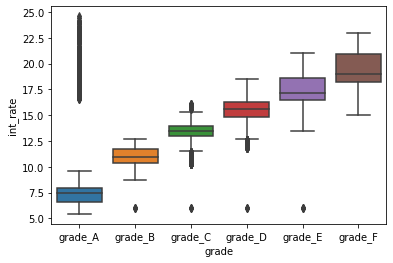

In [4]:
# interest rate variation
grades = [col for col in df.columns if col.startswith('grade')]
df['grade'] = df[grades].idxmax(axis=1)
sns.boxplot(data=df,x='grade',y='int_rate',order=grades)
df = df.drop(columns='grade')

# Regularisation and double selection

In [5]:
# lasso example

# data 
y = df['default']
X = df.drop(columns=['default','int_rate']).copy()
# no test set because this is just an example

# fit lasso for different penalties, save coefficients
pens = [10**(-k) for k in range(1,6)]
coefs = pd.DataFrame(index=pens,columns=X.columns)
for i,pen in enumerate(pens):
    lasso = Lasso(alpha=pen)
    lasso.fit(X,y)
    coefs.iloc[i] = lasso.coef_

Text(0, 0.5, 'coefficient')

<Figure size 1080x864 with 0 Axes>

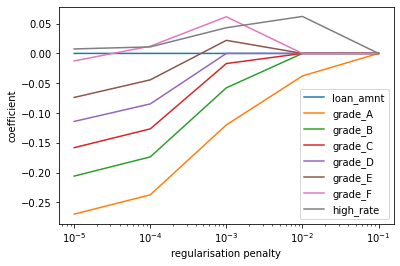

In [6]:
# plot coefficients as a function of regularisation penalty
plt.figure(figsize=(15,12))
coefs.plot()
plt.xscale('log')
plt.xlabel('regularisation penalty')
plt.ylabel('coefficient')
# plt.savefig('../figures/lasso_case_study.pdf')

In [7]:
# double selection method

# sample
y = df['default']
X = df.drop(columns=['default','int_rate'])

# sample splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# separate treatment w and observables x
w_train = X_train['high_rate']
w_test = X_test['high_rate']
X_train = X_train.drop(columns=['high_rate'])
X_test = X_test.drop(columns=['high_rate'])

In [8]:
# shopping list
potential_confounders = []

# step 1: lasso to predict outcome from observables
betas = Lasso(alpha=1e-2).fit(X_train,y_train).coef_ 
cols = X_train.columns[betas != 0]
print('variables that predict default outcome')
print(cols)
potential_confounders.extend(cols)

# step 2: lasso to predict treatment from observables
betas = Lasso(alpha=1e-2).fit(X_train,w_train).coef_ 
cols = list(X_train.columns[betas != 0])
print('\nvariables that predict high interest rate treatment')
print(cols)
potential_confounders.extend(cols)

print('\npotential confounders')
print(potential_confounders)

print('\nnot potential confounders')
print([col for col in X_train.columns if col not in potential_confounders])

variables that predict default outcome
Index(['loan_amnt', 'grade_A', 'grade_B'], dtype='object')

variables that predict high interest rate treatment
['loan_amnt', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E']

potential confounders
['loan_amnt', 'grade_A', 'grade_B', 'loan_amnt', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E']

not potential confounders
['grade_F']


In [9]:
# step 4: run final model spec

# do this on test sample
# include potential confounders and treatment
X_OLS = X_test[list(set(potential_confounders))].join(w_test)
y_OLS = y_test

# fit unpenalised regression (statsmodels better than sklearn for this)
mod = sm.OLS(y_OLS,X_OLS)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                default   R-squared (uncentered):                   0.171
Model:                            OLS   Adj. R-squared (uncentered):              0.170
Method:                 Least Squares   F-statistic:                              625.1
Date:                Tue, 30 May 2023   Prob (F-statistic):                        0.00
Time:                        17:52:14   Log-Likelihood:                         -8013.4
No. Observations:               21261   AIC:                                  1.604e+04
Df Residuals:                   21254   BIC:                                  1.610e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Nuisance parameters and transformed outcomes

In [10]:
# transformed outcome tree

# sample
y = df['default']
X = df.drop(columns=['default','int_rate'])

# sample splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# separate treatment w and observables x
w_train = X_train['high_rate']
w_test = X_test['high_rate']
X_train = X_train.drop(columns=['high_rate'])
X_test = X_test.drop(columns=['high_rate'])

# get propensity scores on training data using logistic regression
logit = LogisticRegression().fit(X_train,w_train)
ps_train = logit.predict_proba(X_train)[:,1]
ps_test = logit.predict_proba(X_test)[:,1]

In [11]:
ps_train

array([0.01484114, 0.01394112, 0.02411414, ..., 0.75532994, 0.08735517,
       0.26587198])

In [12]:
import os
os.environ["PATH"] += os.pathsep + '/opt/local/bin'

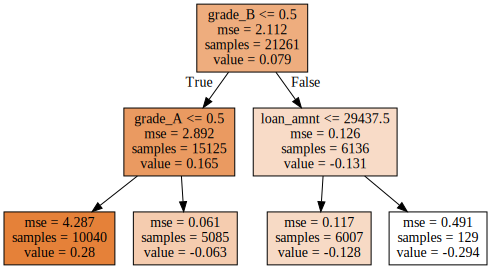

Text(0, 0.5, 'treatment effect tau(x)')

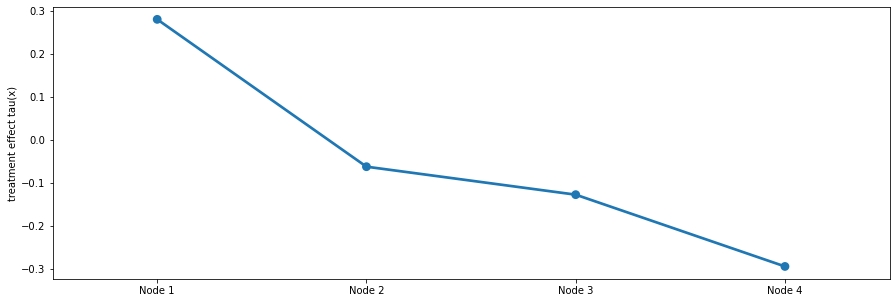

In [13]:
# transformed outcome on training and test data
ystar_train = (w_train - ps_train) / (ps_train * (1-ps_train)) * y_train
ystar_test = (w_test - ps_test) / (ps_test * (1-ps_test)) * y_test

# tree to predict transformed outcomes 
tree = DecisionTreeRegressor(max_depth = 2)
tree.fit(X_train,ystar_train)

# visualise tree
graph = Source(export_graphviz(tree, out_file=None, feature_names=X_train.columns, filled = True))
display(SVG(graph.pipe(format='svg')))

# visualise predictions on each node in test data
leaves = tree.apply(X_test)
yhat = tree.predict(X_test)
plt.figure(figsize=(15,5))
s = sns.pointplot(y = yhat, x = leaves,ci=95)
s = s.set_xticklabels(['Node %d' %(d+1) for d in range(4)])
plt.ylabel('treatment effect tau(x)')

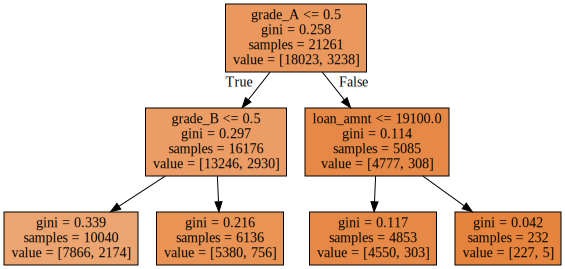

In [14]:
# for comparison: standard tree
# fit model and specify max depth
tree = DecisionTreeClassifier(max_depth = 2)
tree.fit(X_train,y_train)

# visualise tree
graph = Source(export_graphviz(tree, out_file=None, feature_names=X_train.columns, filled = True))
display(SVG(graph.pipe(format='svg')))